In [1]:
import sys

import logging
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg as splin

_has_matplotlib = True
try:
    import matplotlib.pyplot as plt
except ImportError:
    _has_matplotlib = False
    logging.warning("Matplotlib is not installed - plotting "
                    "functionality disabled")


def log_iteration(ii, s0, u, g):
    relative_change = np.linalg.norm(s0) / np.linalg.norm(u)
    g_norm = np.linalg.norm(g)
    logging.info('iteration {0:4d}: relative change = {1:.3e}, '
                 'gradient norm = {2:.3e}\n'.format(ii,
                                                    relative_change,
                                                    g_norm))


def TVRegDiff(data, itern, alph, u0=None, scale='small', ep=1e-6, dx=None,
              plotflag=_has_matplotlib, diagflag=True, precondflag=True,
              diffkernel='abs', cgtol=1e-4, cgmaxit=100):
    """
    Estimate derivatives from noisy data based using the Total 
    Variation Regularized Numerical Differentiation (TVDiff) 
    algorithm.
    Parameters
    ----------
    data : ndarray
        One-dimensional array containing series data to be
        differentiated.
    itern : int
        Number of iterations to run the main loop.  A stopping
        condition based on the norm of the gradient vector g
        below would be an easy modification.  No default value.
    alph : float    
        Regularization parameter.  This is the main parameter
        to fiddle with.  Start by varying by orders of
        magnitude until reasonable results are obtained.  A
        value to the nearest power of 10 is usally adequate.
        No default value.  Higher values increase
        regularization strenght and improve conditioning.
    u0 : ndarray, optional
        Initialization of the iteration.  Default value is the
        naive derivative (without scaling), of appropriate
        length (this being different for the two methods).
        Although the solution is theoretically independent of
        the initialization, a poor choice can exacerbate
        conditioning issues when the linear system is solved.
    scale : {large' or 'small' (case insensitive)}, str, optional   
        Default is 'small'.  'small' has somewhat better boundary
        behavior, but becomes unwieldly for data larger than
        1000 entries or so.  'large' has simpler numerics but
        is more efficient for large-scale problems.  'large' is
        more readily modified for higher-order derivatives,
        since the implicit differentiation matrix is square.
    ep : float, optional 
        Parameter for avoiding division by zero.  Default value
        is 1e-6.  Results should not be very sensitive to the
        value.  Larger values improve conditioning and
        therefore speed, while smaller values give more
        accurate results with sharper jumps.
    dx : float, optional    
        Grid spacing, used in the definition of the derivative
        operators.  Default is the reciprocal of the data size.
    plotflag : bool, optional
        Flag whether to display plot at each iteration.
        Default is True.  Useful, but adds significant
        running time.
    diagflag : bool, optional
        Flag whether to display diagnostics at each
        iteration.  Default is True.  Useful for diagnosing
        preconditioning problems.  When tolerance is not met,
        an early iterate being best is more worrying than a
        large relative residual.
    precondflag: bool, optional
        Flag whether to use a preconditioner for conjugate gradient solution.
        Default is True. While in principle it should speed things up, 
        sometimes the preconditioner can cause convergence problems instead,
        and should be turned off. Note that this mostly makes sense for 'small'
        scale problems; for 'large' ones, the improved preconditioner is one
        of the main features of the algorithms and turning it off defeats the
        point.
    diffkernel: str, optional
        Kernel to use in the integral to smooth the derivative. By default it's
        the absolute value, |u'| (value: "abs"). However, it can be changed to
        being the square, (u')^2 (value: "sq"). The latter produces smoother
        derivatives, whereas the absolute values tends to make them more blocky.
        Default is abs.
    cgtol: float, optional
        Tolerance to use in conjugate gradient optimisation. Default is 1e-4.
    cgmaxit: int, optional
        Maximum number of iterations to use in conjugate gradient optimisation. 
        Default is 100
    Returns
    -------
    u : ndarray
        Estimate of the regularized derivative of data.  Due to
        different grid assumptions, length(u) = length(data) + 1
        if scale = 'small', otherwise length(u) = length(data).
    """

    # Make sure we have a column vector
    data = np.array(data)
    assert len(data.shape) == 1, "data is not one-dimensional"
    # Get the data size.
    n = len(data)

    # Default checking. (u0 is done separately within each method.)
    if dx is None:
        dx = 1.0 / n

    # Different methods for small- and large-scale problems.
    if (scale.lower() == 'small'):

        # Differentiation operator
        d0 = -np.ones(n)/dx
        du = np.ones(n-1)/dx
        dl = np.zeros(n-1)
        dl[-1] = d0[-1]
        d0[-1] *= -1

        D = sparse.diags([dl, d0, du], [-1, 0, 1])
        DT = D.transpose()

        # Antidifferentiation and its adjoint
        def A(x): return (np.cumsum(x) - 0.5 * (x + x[0])) * dx

        def AT(x): return np.concatenate([[sum(x[1:])/2.0],
                                          (sum(x)-np.cumsum(x)+0.5*x)[1:]])*dx

        # Default initialization is naive derivative

        if u0 is None:
            u0 = D*data

        u = u0.copy()
        # Since Au( 0 ) = 0, we need to adjust.
        ofst = data[0]
        # Precompute.
        ATb = AT(ofst - data)        # input: size n

        # Main loop.
        for ii in range(1, itern+1):
            if diffkernel == 'abs':
                # Diagonal matrix of weights, for linearizing E-L equation.
                Q = sparse.spdiags(1. / (np.sqrt((D * u)**2 + ep)), 0, n, n)
                # Linearized diffusion matrix, also approximation of Hessian.
                L = dx * DT * Q * D
            elif diffkernel == 'sq':
                L = dx * DT * D
            else:
                raise ValueError('Invalid diffkernel value')

            # Gradient of functional.
            g = AT(A(u)) + ATb + alph * L * u

            # Prepare to solve linear equation.
            if precondflag:
                # Simple preconditioner.
                P = alph * sparse.spdiags(L.diagonal() + 1, 0, n, n)
            else:
                P = None

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n, n), linop)

            s, info_i = sparse.linalg.cg(
                linop, g, x0=None, tol=cgtol, maxiter=cgmaxit,
                callback=None, M=P, atol='legacy')

            if diagflag:
                log_iteration(ii, s[0], u, g)
                if (info_i > 0):
                    logging.warning(
                        "WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    logging.warning("WARNING - illegal input or breakdown")

            # Update solution.
            u = u - s
            # Display plot.
            if plotflag:
                plt.plot(u)
                plt.show()

    elif (scale.lower() == 'large'):

        # Construct anti-differentiation operator and its adjoint.
        def A(v): return np.cumsum(v)

        def AT(w): return (sum(w) * np.ones(len(w)) -
                           np.transpose(np.concatenate(([0.0],
                                                        np.cumsum(w[:-1])))))
        # Construct differentiation matrix.
        c = np.ones(n)
        D = sparse.spdiags([-c, c], [0, 1], n, n) / dx
        mask = np.ones((n, n))
        mask[-1, -1] = 0.0
        D = sparse.dia_matrix(D.multiply(mask))
        DT = D.transpose()
        # Since Au( 0 ) = 0, we need to adjust.
        data = data - data[0]
        # Default initialization is naive derivative.
        if u0 is None:
            u0 = np.concatenate(([0], np.diff(data)))
        u = u0
        # Precompute.
        ATd = AT(data)

        # Main loop.
        for ii in range(1, itern + 1):

            if diffkernel == 'abs':
                # Diagonal matrix of weights, for linearizing E-L equation.
                Q = sparse.spdiags(1. / (np.sqrt((D * u)**2 + ep)), 0, n, n)
                # Linearized diffusion matrix, also approximation of Hessian.
                L = DT * Q * D
            elif diffkernel == 'sq':
                L = DT * D
            else:
                raise ValueError('Invalid diffkernel value')

            # Gradient of functional.
            g = AT(A(u)) - ATd
            g = g + alph * L * u
            # Build preconditioner.
            if precondflag:
                c = np.cumsum(range(n, 0, -1))
                B = alph * L + sparse.spdiags(c[::-1], 0, n, n)
                # droptol = 1.0e-2
                R = sparse.dia_matrix(np.linalg.cholesky(B.todense()))
                P = np.dot(R.transpose(), R)
            else:
                P = None
            # Prepare to solve linear equation.

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n, n), linop)

            s, info_i = sparse.linalg.cg(
                linop, -g, x0=None, tol=cgtol, maxiter=cgmaxit, callback=None,
                M=P, atol='legacy')
            if diagflag:
                log_iteration(ii, s[0], u, g)
                if (info_i > 0):
                    logging.warning(
                        "WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    logging.warning("WARNING - illegal input or breakdown")

            # Update current solution
            u = u + s
            # Display plot
            if plotflag:
                plt.plot(u / dx)
                plt.show()

        u = u / dx

    return u


if __name__ == "__main__":

    # Command line operation
    import argparse as ap

    parser = ap.ArgumentParser(description='Compute the derivative of a '
                               'noisy function with the TVRegDiff method')
    parser.add_argument('dat_file', type=str,
                        help='Tabulated ASCII file with the data'
                        ' to differentiate')
    parser.add_argument('-iter', type=int, default=10,
                        help='Number of iterations')
    parser.add_argument('-colx', type=int, default=0,
                        help='Index of the column containing the X data '
                        '(must be regularly spaced)')
    parser.add_argument('-coly', type=int, default=1,
                        help='Index of the column containing the Y data')
    parser.add_argument('-a', type=float, default=5e-2,
                        help='Regularization parameter')
    parser.add_argument('-ep', type=float, default=1e-5,
                        help='Parameter for avoiding division by zero')
    parser.add_argument('-lscale', action='store_true', default=False,
                        help='Use Large instead of Small scale algorithm')
    parser.add_argument('-plot', action='store_true', default=False,
                        help='Plot result with Matplotlib at the end')
    parser.add_argument('-sq', action='store_true', default=False,
                        help='Use square instead of abs kernel for the'
                        ' functional')
    parser.add_argument('-nop', action='store_true', default=False,
                        help='Do not use preconditioner')

    args = parser.parse_args()

    data = np.loadtxt(args.dat_file)
    X = data[:, args.colx]
    Y = data[:, args.coly]

    dX = X[1] - X[0]

    dYdX = TVRegDiff(Y, args.iter, args.a, dx=dX, ep=args.ep,
                     scale=('large' if args.lscale else 'small'),
                     plotflag=False, precondflag=(not args.nop),
                     diffkernel=('sq' if args.sq else 'abs'))

    if (_has_matplotlib):

        plt.plot(X, Y, label='f(x)', c=(0.2, 0.2, 0.2), lw=0.5)
        plt.plot(X, np.gradient(Y, dX),
                 label='df/dx (numpy)', c=(0, 0.3, 0.8), lw=1)
        plt.plot(X, dYdX, label='df/dx (TVRegDiff)',
                 c=(0.8, 0.3, 0.0), lw=1)
        plt.legend()
        plt.show()

usage: ipykernel_launcher.py [-h] [-iter ITER] [-colx COLX] [-coly COLY]
                             [-a A] [-ep EP] [-lscale] [-plot] [-sq] [-nop]
                             dat_file
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

c:\users\kts260\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import pandas as pd
import os

In [14]:
# read and plot the test data
file_name = input('please type in the file name:' ) + '.xlsx'
file_path = input('please type in the file path:')
file = os.path.join(file_path, file_name) 
data = pd.read_excel(file)
print(data.head())

please type in the file name: 20200810-173827 test helicase+gp2.5  working on PKYB1 DNA  #012-002
please type in the file path: C:\Users\KTS260\Google Drive\T7 Helicase data


   Unnamed: 0  time    basepairs
0           0  4049  8340.297001
1           1  4099  8327.105088
2           2  4150  8324.562511
3           3  4198  8334.969711
4           4  4249  8319.861483


In [15]:
x = data['time']
x = np.array(x)
y = data['basepairs']
y = np.array(y)
# z = data['df/dx']
# z = np.array(z)

<function matplotlib.pyplot.show(close=None, block=None)>

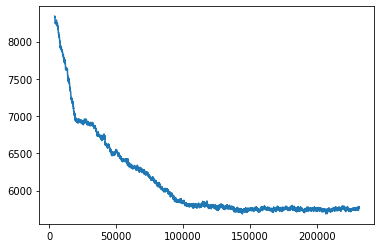

In [16]:
plt.plot(x,y)
# plt.plot(x,z)
plt.show

In [ ]:
u = TVRegDiff(y, 0.1*len(y), 5)

In [7]:
print(u)

[ 3.73506412  3.73506695  3.7350599   3.73505095  3.73505042  3.73505311
  3.73503231  3.73502527  3.73502806  3.7350077   3.73500251  3.7349835
  3.73496833  3.7349529   3.73494593  3.73496542  3.73495072  3.73482416
  3.73483182  3.73485268  3.67760814  3.2932089   3.05527547  2.88193993
  2.62683628  2.36652969  1.7848825   1.13655465  1.0944846   0.72297344
  0.38868333 -0.33178388 -0.66896118 -0.74934243 -1.15554294 -1.17989078
 -1.25890161 -1.64521383 -1.84748753 -1.99539042 -2.08948164 -2.32154942
 -3.02457337 -3.68559545 -3.75250235 -3.86747665 -4.25143627 -4.59190829
 -4.64388275 -4.6440882  -4.64306581 -4.6435137  -4.64370967 -4.6437108
 -4.64371038 -4.64369538 -4.6436753  -4.64364712 -4.64364197 -4.64364032
 -4.64365468 -4.64365259 -4.64365378 -4.64366246 -4.64368527 -4.64368483
 -4.64369403 -4.6436957  -4.64370191 -4.64372347 -4.6437703  -4.64377387
 -4.64373956 -4.64371964 -4.64357805 -4.64336723 -4.64334678 -4.64319362
 -4.35435409 -3.7121095  -3.5034746  -3.33135617 -3.2

<function matplotlib.pyplot.show(close=None, block=None)>

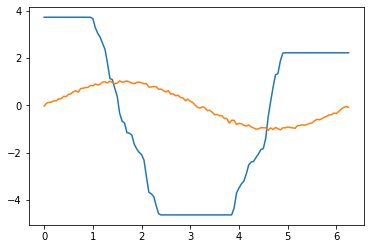

In [12]:
plt.figure()
plt.plot(x,u)
plt.plot(x,y)
plt.show